# Boundary Modeling Example

In [1]:
import pygeostat as gs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
gs.__path__

['C:\\Users\\Mosi\\Documents\\Git\\pygeostat\\pygeostat']

## Project Settings

### Pygeostat Settings

In [3]:
gs.gsParams['data.griddef'] = \
'''120 5.0 10.0 
110 1205.0 10.0 
1 0.5 1.0'''

gs.gsParams['plotting.cmap_cat'] = 'bwr'
gs.gsParams['plotting.cmap'] = 'bwr'

gs.gsParams['data.tmin'] = -998
gs.gsParams['data.null'] = -999

gs.gsPlotStyle['figure.figsize']= (5, 5)
gs.gsPlotStyle['font.size']= 12

In [4]:
nreal = 100
gs.gsParams['data.nreal'] = nreal

In [5]:
print(gs.gsParams)

config.autoload.gsparams: False
config.autoload.gsplotstyle: False
config.getpar: False
config.nprocess: 4
config.verbose: True
data.cat: None
data.catdict: None
data.dh: None
data.fix_legacy_null: False
data.griddef: 120 5.0 10.0 
110 1205.0 10.0 
1 0.5 1.0
data.ifrom: None
data.io.fortran_default: False
data.io.pandas_engine: python
data.ito: None
data.legacy_null: [-999, -998, -99, -98]
data.nreal: 100
data.null: -999.0
data.null_vtk: 0.0
data.tmin: -998.0
data.write.fortran_floatfmt: g16.8
data.write.python_floatfmt: %.6f
data.write_vtk.cdtype: float64
data.write_vtk.vdtype: float64
data.wts: None
data.x: None
data.y: None
data.z: None
plotting.assumecat: 11
plotting.axis_xy: False
plotting.axis_xy_spatial: False
plotting.cmap: bwr
plotting.cmap_cat: bwr
plotting.gammasize: 3.0
plotting.grid: False
plotting.histplt.cdfcolor: .5
plotting.histplt.edgecolor: k
plotting.histplt.edgeweight: None
plotting.histplt.facecolor: .9
plotting.histplt.histbins: 15
plotting.histplt.stat_blk: all


### Directories

In [6]:
# Create the output directory
outdir = 'Output/'
gs.mkdir(outdir)

## Loading data

In [7]:
dat = gs.DataFile('./data/PRM_Boundary.dat', cat='Domain Indicator', griddef=gs.gsParams['data.griddef'])
dat.head()

,HoleID,X,Y,Domain Indicator
0,1.0,85.36,1575.28,0.0
1,2.0,1105.62,1225.45,0.0
2,3.0,405.63,2135.75,1.0
3,4.0,195.84,2185.05,0.0
4,5.0,235.89,1865.70,1.0


In [8]:
print(dat.describe())

           HoleID            X            Y  Domain Indicator
count  301.000000   301.000000   301.000000        301.000000
mean   151.000000   585.313156  1743.896678          0.764120
std     87.035433   326.620938   290.727190          0.425255
min      1.000000     5.370000  1205.440000          0.000000
25%     76.000000   325.710000  1495.580000          1.000000
50%    151.000000   605.210000  1735.870000          1.000000
75%    226.000000   835.830000  1985.890000          1.000000
max    301.000000  1185.420000  2285.760000          1.000000


In [9]:
print('x and y attributes:', dat.x, dat.y)
print('categorical attribute:', dat.cat)
print('data file type:', dat.dftype)

x and y attributes: X Y
categorical attribute: Domain Indicator
data file type: point


## Location Map

In [10]:
gs.gsParams['data.catdict'] = {1: 'Inside', 0: 'Outside'}

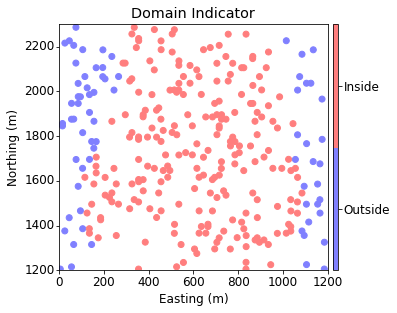

In [11]:
gs.locmap(dat)

## Distance Function Modeling

### Calculate Signed Distance Function

**Signed distance function**

$df(u_\alpha) = +(u_\alpha - u_\beta) \;\; if \;\; i(u_\alpha) = 0 $

$df(u_\alpha) = -(u_\alpha - u_\beta) \;\; if \;\; i(u_\alpha) = 1 $

**Modified signed distance function**

$df(u_\alpha) = +(u_\alpha - u_\beta) + C \;\; if \;\; i(u_\alpha) = 0 $

$df(u_\alpha) = -(u_\alpha - u_\beta) - C \;\; if \;\; i(u_\alpha) = 1 $

In [12]:
selected_c = 50

In [13]:
print(dat.columns)

Index(['HoleID', 'X', 'Y', 'Domain Indicator'], dtype='object')


In [14]:
# Intilize the Program wrapper to point to the correct executable
dfcalc = gs.Program( 'dfcalc')
dfcalc.getparfile()

C:\Users\Mosi\Desktop\CourseMaterial\tmpusbs75ca/dfcalc.par has been copied to the clipboard


In [15]:
parstr = """            Parameters for DFCalc
            *********************
 
START OF PARAMETERS:
{datafl}                     -file with input data
1 2 3 0 4                    -column for DH,X,Y,Z,Ind
1                            -in code: indicator for inside domain
0.0  0.0  0.0                -angles for anisotropy ellipsoid
1.0  1.0                     -first and second anisotropy ratios (typically <=1)
0.0                          -proportion of drillholes to remove
69067                        -random number seed
{c}                            -C
{outfl}                       -file for distance function output
nofile.out                 -file for excluded drillholes output
  

"""
pars = dict(datafl=dat.flname, c=selected_c,
            outfl=outdir+'df_calc.out')
dfcalc.run(parstr=parstr.format(**pars))

Calling:  ['dfcalc', 'temp']

 DFCalc Version: 1.001

  data file = ./data/PRM_Boundary.dat                 
  columns =            1           2           3           0           4
  in code =            1
  anisotropy angles =   0.000000000000000E+000  0.000000000000000E+000
  0.000000000000000E+000
  anisotropy ratios =    1.00000000000000        1.00000000000000     
  proportion to exclude =   0.0000000E+00
  random number seed =        69067
  C =    50.00000    
  data file = Output/df_calc.out                      
  data file = nofile.out                              
 
  Storing
 
  Calculating DF

 DFCalc Version: 1.001



In [16]:
dat_df = gs.DataFile(outdir+'df_calc.out')
dat_df.head()

,DH,X,Y,Z,Ind,DF
0,1.0,85.360001,1575.28,0.0,0.0,100.18436
1,2.0,1105.620000,1225.45,0.0,0.0,209.89038
2,3.0,405.630000,2135.75,0.0,1.0,-206.24744
3,4.0,195.840000,2185.05,0.0,0.0,157.58852
4,5.0,235.890000,1865.70,0.0,1.0,-129.98056


In [17]:
dat_df = gs.DataFile(outdir+'df_calc.out', cat='Ind', griddef=gs.gsParams['data.griddef'])
dat_df.rename({dat_df.variables:'Distance Function'})
dat_df.head()

,DH,X,Y,Z,Ind,Distance Function
0,1.0,85.360001,1575.28,0.0,0.0,100.18436
1,2.0,1105.620000,1225.45,0.0,0.0,209.89038
2,3.0,405.630000,2135.75,0.0,1.0,-206.24744
3,4.0,195.840000,2185.05,0.0,0.0,157.58852
4,5.0,235.890000,1865.70,0.0,1.0,-129.98056


In [18]:
print('x and y attributes:', dat_df.x, dat_df.y)
print('categorical attribute:', dat_df.cat)

x and y attributes: X Y
categorical attribute: Ind


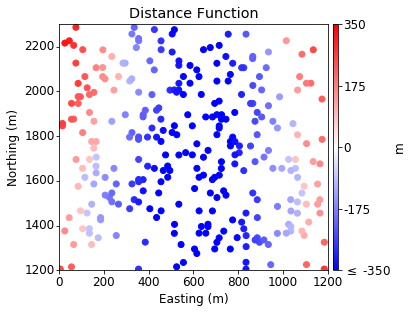

In [19]:
gs.locmap(dat_df, vlim=(-350,350), cbar_label='m')

### Infer the Variogram model for the distance function estimation

#### Calculate and model the indicator varigram

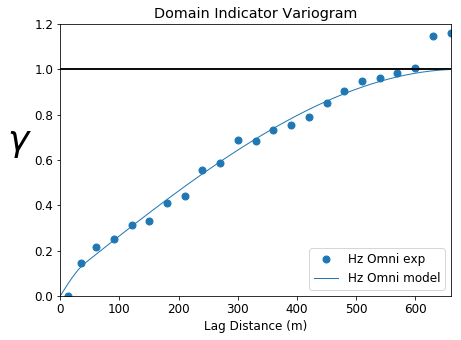

In [20]:
# Initialize the variogram object
varg_ind = gs.Variogram(dat_df, dat_df.cat, variostd=True, mute=True, 
                        ndim=2, ndir=1, omnihz=True)

# Set required parameters before calculating the experimental 
#variogram
varg_ind.update_calcpars(nlags=22, lagdist=30, lagtol=20, 
                         azm=0, azmtol=90, bandhorz=1.0e21)
varg_ind.varcalc()

# Set required parameters before modeling the variogram
varg_ind.update_modelpars(c0=0.0, it=1, nst=2)
varg_ind.fitmodel(maxiter=2500, sill=1.0)

# Plot the variogram
gs.gsParams['plotting.varplt.ms'] = 7
fig = varg_ind.plot(model=True, titles=dat.cat+' Variogram', 
                    figsize=(7, 5))

In [21]:
# Print the applied and inferred parameters that were used in the calculation
print('\nExperimental calculation parameters:')
for key, val in varg_ind.calcpars.items():
    print(key+' = ', val)

# Print the first few rows of the experimental variograms table
print('\n Experimental variogram:\n', varg_ind.expvargs[0].head(20))

# Print Variogram Model
print('\n Indicator Variogram Model: {}\n'.format(varg_ind.model))


Experimental calculation parameters:
variotypes =  1
variotails =  Ind
varioheads =  Ind
azm =  [0.0]
dip =  [0.0]
tilt =  [0.0]
azmtol =  [90]
diptol =  [90]
nlags =  [22]
lagdist =  [30]
lagtol =  [20]
bandhorz =  [1e+21]
bandvert =  [1e+21]
variostd =  True
variosills =  None
strict =  True
variocutcat =  None
ang1 =  0.0
ang2 =  0
ang3 =  0

 Experimental variogram:
              h     vario  numpairs  azimuth  dip
0    13.031283  0.000000        54      0.0  0.0
1    34.568263  0.143677       502      0.0  0.0
2    61.039935  0.214421      1035      0.0  0.0
3    90.202239  0.251724      1631      0.0  0.0
4   120.518400  0.312100      1991      0.0  0.0
5   149.784048  0.329685      2356      0.0  0.0
6   180.247873  0.411699      2830      0.0  0.0
7   209.873195  0.439940      3178      0.0  0.0
8   240.267999  0.553392      3514      0.0  0.0
9   269.257819  0.585677      3775      0.0  0.0
10  300.068492  0.686402      4094      0.0  0.0
11  330.163047  0.682590      4316   

#### Calculate Gaussian Variogram

The Gaussian variogram that yields the indicator variogram after truncation of a Gaussian random field is calculated. This Gaussian variogram is modeled and input to $df$ modeing. 

**Proportion calculation**

The proportion is required input to bigaus2 below along with the indicator variogram.

In [22]:
proportion = sum(dat_df[dat_df.cat])/len(dat_df)
print('Proportion of inside data: %{:.2f}'.format(proportion*100))

Proportion of inside data: %76.41


In [23]:
bigaus2 = gs.Program(program='bigaus2')
bigaus2.getparfile()

C:\Users\Mosi\Desktop\CourseMaterial\tmpa3e5d4z1/bigaus2.par has been copied to the clipboard


In [24]:
parstr = """                  Parameters for BIGAUS2
                  **********************

START OF PARAMETERS:
1                                 -input mode (1) model or (2) variogram file
nofile.out                        -file for input variogram
{proportion}                      -threshold/proportion
2                                 -calculation mode (1) NS->Ind or (2) Ind->NS
{outfl}                           -file for output of variograms
1                                 -number of thresholds
{proportion}                      -threshold cdf values
1   {nlag}                            -number of directions and lags
{major}   0.0    {lag}                  -azm(1), dip(1), lag(1)
{varstr}
"""
pars = dict(proportion=proportion, major=varg_ind.major[0],
            lag=varg_ind.calcpars['lagdist'][0],
            nlag=varg_ind.calcpars['nlags'][0],
            outfl=outdir+'bigaus2.out',
            varstr=varg_ind.model)
bigaus2.run(parstr=parstr.format(**pars), nogetarg=True)

Calling:  ['bigaus2', 'temp']

 BIGAUS2 Version: 2.200

 Which parameter file do you want to use?
  input mode =            1
  input file = nofile.out                              
  threshold probability =   0.7641196    
  calculation mode =            2
  output file = Output/bigaus2.out                      
  number of cutoffs =            1
  cutoffs =   0.7641196    
  ndir,nlag =            1          22
  azm, dip, lag =   0.0000000E+00  0.0000000E+00   30.00000    
  x,y,z offsets =   0.0000000E+00   30.00000      0.0000000E+00
  nst, c0 =            2  0.0000000E+00
  it,cc,ang[1,2,3] =             1  5.7094198E-02  0.0000000E+00  0.0000000E+00
  0.0000000E+00
  a1 a2 a3 =    41.52386       41.5238590015818        41.5238590015818     
  it,cc,ang[1,2,3] =             1  0.9429058      0.0000000E+00  0.0000000E+00
  0.0000000E+00
  a1 a2 a3 =    676.1333       676.133286836047        676.133286836047     

 BIGAUS2 Version: 2.200 Finished




In [25]:
expvargs = gs.readvarg(outdir+'bigaus2.out', 'all')
expvargs.head()

,Number,Distance,Value,Points,Head,Tail
0,1,0.0,0.000,1000,1.00000,0.00000
1,2,30.0,0.014,1000,0.98607,0.01393
2,3,60.0,0.036,1000,0.96434,0.03566
3,4,90.0,0.064,1000,0.93612,0.06388
4,5,120.0,0.100,1000,0.90036,0.09964


In [26]:
# Add requisite fields
expvargs['azimuth']=0
expvargs['dip'] = 0

# Rename existing fields to the standard fields
expvargs.rename({'Value':'vario', 'Distance':'h', 'Points':'numpairs'})

# Drop the extraneous fields
expvargs.drop(['Head', 'Tail'])

# Demonstrate the present and required form
expvargs.head()

,Number,h,vario,numpairs,azimuth,dip
0,1,0.0,0.000,1000,0,0
1,2,30.0,0.014,1000,0,0
2,3,60.0,0.036,1000,0,0
3,4,90.0,0.064,1000,0,0
4,5,120.0,0.100,1000,0,0


#### Model the Gaussian Variogram


 Gaussian Variogram Model: 2    0.010000000              -  nst, nugget effect
3    0.065218314   20.0   0.0   0.0   - it,cc,ang1,ang2,ang3
       702.479747558056    702.479747558056    702.479747558056       - a_hmax, a_hmin, a_vert
3    0.924781686   20.0   0.0   0.0   - it,cc,ang1,ang2,ang3
       732.6035271495072    732.6035271495072    732.6035271495072       - a_hmax, a_hmin, a_vert



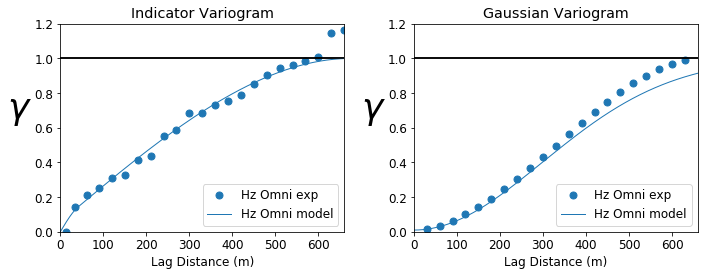

In [27]:
# Initialize the variogram Object
varg_gaus = gs.Variogram(variostd=True, mute=True, ndim=2, ndir=1, omnihz=True)

# Assign some calculation parameters, although they are only correspond 
# with the previously calculated expvargs in this case (rather than being used 
# in the calculation)
varg_gaus.update_calcpars(nlags=22, lagdist=30, azm=20)
varg_gaus.majorexp = expvargs.data

# Set required parameters before modeling the variogram
varg_gaus.update_modelpars(c0=0.01, it=[3,3], nst=2, ang2=[[0,0],[0,0]], 
                           ang3=[[0,0],[0,0]])
varg_gaus.fitmodel(maxiter=2500, sill=1.0)

# Print the variogram model
print('\n Gaussian Variogram Model: {}\n'.format(varg_gaus.model))

# Plot the indicator and Gaussian variogram
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for varg, ax, title in zip([varg_ind, varg_gaus], axes, 
                           ['Indicator Variogram', 'Gaussian Variogram']):
    fig = varg.plot(model=True, titles=title, axes=ax)
fig.tight_layout()

### Estimate distance function across the grid

In [28]:
kd3dn = gs.Program(program='kt3dn')
kd3dn.getparfile()

C:\Users\Mosi\Desktop\CourseMaterial\tmpsxzxk34o/kt3dn.par has been copied to the clipboard


In [29]:
parstr = """                 Parameters for KT3DN
                               ********************
START OF PARAMETERS:
{input_file}                     -file with data
1  2  3  0  6  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
nofile.out                       -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
{out_sum}                        -file for debugging output (see note)
{out_grid}                       -file for kriged output (see GSB note)
{gridstr}
1    1      1                    -x,y and z block discretization
1 100   100    1                 -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
700.0 700.0  500.0               -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
1                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.0  0.6  0.8 1.6                -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varmodelstr}
"""
pars = dict(input_file=outdir+'df_calc.out', 
            out_grid=outdir+'kt3dn_df.gsb',
            out_sum=outdir+'kt3dn_sum.out',
            gridstr=gs.gsParams['data.griddef'], varmodelstr=varg_gaus.model)
kd3dn.run(parstr=parstr.format(**pars))

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.330

  data file = Output/df_calc.out                      
  columns =            1           2           3           0           6
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = nofile.out                              
  debugging level =            0
  debugging file = Output/kt3dn_sum.out                    
  GSB-style output file = Output/kt3dn_df.gsb                     
  nx, xmn, xsiz =          120   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =          110   1205.00000000000        10.0000000000000     
  nz, zmn, zsiz =            1  0.500000000000000        1.00000000000000     
  block discretization:           1           1           1
  ndmin,ndmax =            1    

In [30]:
est_df = gs.DataFile(flname=os.path.join(outdir+'kt3dn_df.gsb'))
est_df.head()

,Estimate,EstimateVariance
0,252.829941,0.019058
1,248.566818,0.020119
2,243.088333,0.022141
3,236.715958,0.022956
4,229.573334,0.022677


In [31]:
est_df.drop('EstimateVariance')
est_df.rename({'Estimate':'Distance Function'})
est_df.head()

,Distance Function
0,252.829941
1,248.566818
2,243.088333
3,236.715958
4,229.573334


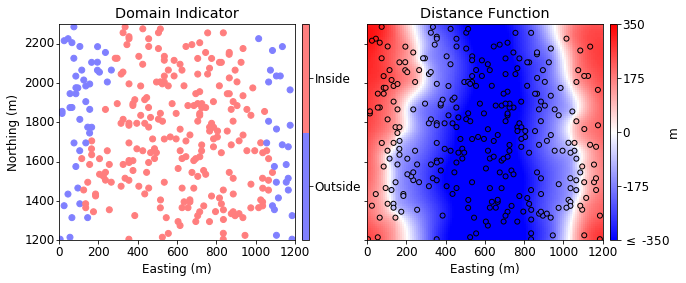

In [32]:
# Generate a figure object
fig, axes = gs.subplots(1, 2, figsize=(10, 8),cbar_mode='each', 
                        axes_pad=0.8,  cbar_pad=0.1)

# Location map of indicator data for comparison
gs.locmap(dat, ax=axes[0])

# Map of distance function data and estimate
gs.pixelplt(est_df, pointdata=dat_df, 
            pointkws={'edgecolors':'k', 's':25},
            cbar_label='m', vlim=[-350,350], ax=axes[1])

## 6. Boundary Simulation

This section is subdivided into 4 sub-sections:
1. Simulate an unconditional but spatially correlated Gaussian deviate using SGSIM
2. Transform this Gaussian deviate into $df$ deviates with a range of  $[−C, C]$
3. Add the $df$ deviates to the $df$ estimate, yielding a $df$ realization
4. Truncate the realization at  $df=0$ , generating a realization of the domain indicator 

### Get the key out file

Adding the $C$ value allows us to define an uncertain area where the boundary realizations can bound within. In this context, the key out file is generated to identify the uncertain grid locations where we can simulate random variables withing $+/-c$. Adding the simulated values to the estimated model, gives us the uncertainty in the boundary modeling.

806 values in, 12394 values out


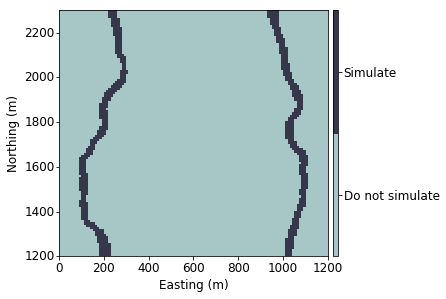

In [33]:
import copy
# Copy the data file
keyout = copy.deepcopy(est_df)

# Initialize a keyout column with 0s (outside)
keyvar = 'Keyout'
keyout[keyvar] = 0

# Generate an index that is true when df <= selected_c
idx = abs(keyout['Distance Function']) <= selected_c
griddef = gs.gsParams['data.griddef']
print('{} values in, {} values out'.format(sum(idx), griddef.count()-sum(idx)))

# The keyout is 1 when the idx is true
# This function must be applied to the DataFrame
keyout.data.loc[idx, keyvar] = 1

# Drop the distance function
keyout.drop('Distance Function')

# Write out
keyout.writefile(os.path.join(outdir+'keyout.gsb'))

# Plot
gs.pixelplt(keyout, cmap='bone_r', catdict={0:'Do not simulate', 1:'Simulate'})

### Simulate the unconditional Gaussian deviates

In [34]:
simdir = os.path.join(outdir+'USGSIM/')
gs.mkdir(simdir)
usgsim = gs.Program(program='usgsim')

In [35]:
varg_h = selected_c*5

parstr = """               Parameters for USGSIM
                              *********************

START OF MAIN:
1                             -number of realizations to generate, 0=kriging
1                             -number of variables being simulated
1                             -number of rock types to consider
{seed}                        -random number seed
{gridstr}
{outfl}                       -file for simulation output
2                             -  output format: (0=reg, 1=coord, 2=binary)
impute.out                    -file for imputed values in case of heterotopic samples
1                             -debugging level: 0,1,2,3
{dbgfile}                     -file for debugging output 

START OF SRCH:
40                            -number of data to use per variable
{varg_h}  {varg_h}   10.0     -maximum search radii (hmax,hmin,vert)
0.0    0.0    0.0             -angles for search ellipsoid
1                             -sort by distance (0) or covariance (1)
1 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use

START OF VARG:
1                             -number of variograms
1  1  1                       -rock type, variable 1, variable 2
1    0.001                    -  number of structures, nugget effect
3    0.999 0.0   0.0   0.0    -  type,variance,ang1,ang2,ang3
 {varg_h}  {varg_h}  50.0     -  a_hmax, a_hmin, a_vert
         
START OF ROCK:
1                             -rock type codes
{keyfl}                       -file with rock types
1                             -column for rock type
"""
# Setup parameters in advance of parallel simulation of 
# each realization, beginning with a dictionary
# parameters that do not vary
pars = dict(gridstr=griddef, varg_h=varg_h, keyfl=os.path.join(outdir,'keyout.gsb'))

# Call pars will be a list of parameters that are applied in parallel
callpars = []

# Random number seeds are initialized with a seed
seeds = gs.rseed_list(nreal, seed=23243)

# Iterate over the realizations, generating a list of
# associated parameter files
for i, seed in enumerate(seeds):
    # parameters that vary by realization
    pars['seed'] = seed
    pars['outfl'] = simdir+'real{}.gsb'.format(i+1)
    pars['dbgfile'] =simdir+'real{}.dbg'.format(i+1)

    # The parstr is formatted by this iteration of pars,
    # which is then appended to the callpars list
    callpars.append(dict(parstr=parstr.format(**pars)))

# Simulate in parallel
gs.runparallel(usgsim, callpars, reportprogress=True)

Creating parallel processes


Pool assembled, asynchronously processing
Asynchronous execution finished.


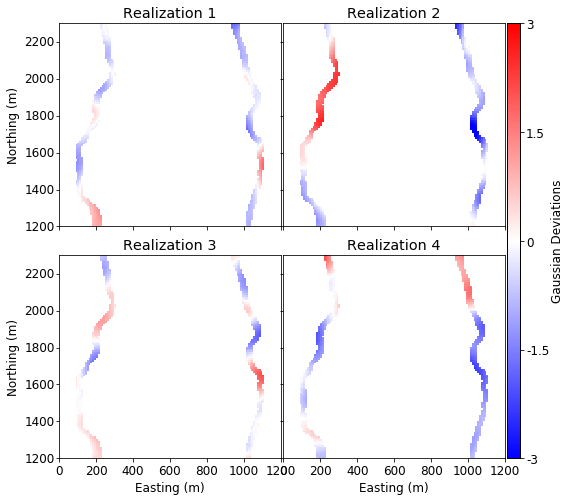

In [36]:
# Generate a figure for the variable realizations
fig, axes = gs.subplots(2, 2, figsize=(10, 8), cbar_mode='single')
# Iterate over the realizations
for real, ax in enumerate(axes):
    sim = gs.DataFile(simdir+'real{}.gsb'.format(real+1))
    gs.pixelplt(sim, title='Realization {}'.format(real+1),
                cbar_label='Gaussian Deviations', ax=ax, vlim=(-3, 3))

### Transform the random normal values into boundary range

In [37]:
# Required package for this calculation
from scipy.stats import norm

# Create a directory for the output
domaindir = 'Domains/'
gs.mkdir(domaindir)

# Generate logical numpy index array that identifies the locations
# where simulation has occured
idx = keyout[keyvar].values == 1

for real in range(nreal):
    # Load the simulated Gaussian deviates and convert to a 
    #flat numpy array
    sim = gs.DataFile(simdir+'real{}.gsb'.format(real+1))
    sim = sim.data.values.flatten()
    
    # Transform the Gaussian deviates to probabilities
    sim = norm.cdf(sim[idx], loc=0.0, scale=1.0)
    
    # Transform the probabilities to distance function deviates
    sim = 2 *selected_c * sim - selected_c

    # Initialize the final realization as the distance function estimate
    df = est_df['Distance Function'].values

    # Add the distance function deviates to the distance function estimate,
    # yielding a distance function realization
    df[idx] = df[idx] + sim

    # If the distance function is greater than 0, the simulated indicator is 1
    sim = (df <= 0).astype(int)

    # Convert the Numpy array to a Pandas DataFrame, which is required 
    # for initializing a DataFile (aside from the demonstrated flname approach).
    # The DataFile is then written out
    sim = pd.DataFrame(data=sim, columns=[dat.cat])
    sim = gs.DataFile(data=sim)
    sim.writefile(domaindir+'real{}.gsb'.format(real+1))

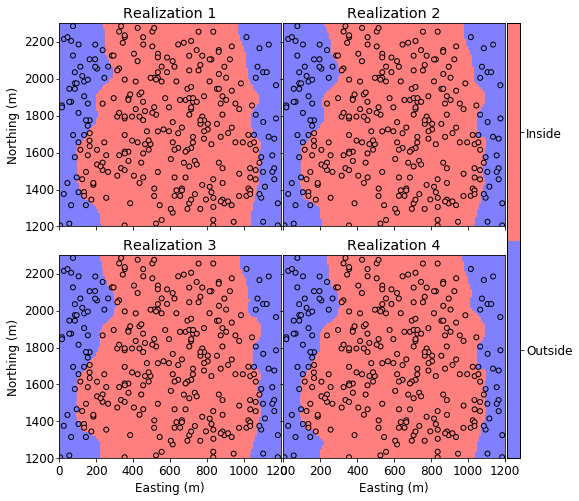

In [38]:
fig, axes = gs.subplots(2, 2, figsize=(10, 8), cbar_mode='single')
for real, ax in enumerate(axes):
    sim = gs.DataFile(domaindir+'real{}.gsb'.format(real+1))
    gs.pixelplt(sim, title='Realization {}'.format(real+1), 
                pointdata=dat, 
                pointkws={'edgecolors':'k', 's':25},
                vlim=(0, 1), ax=ax)